# TX00DQ05-3001 Exercises 4

In [1]:
import numpy as np
import numpy.linalg as LA
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GridWorld:
    """
    A basic grid world environment (based on Sutton & Barto example 4.1)
    without any blows and whistles or argument validation...
    """
    
    def __init__(self, rows, columns, terminal_states: 'Iterable[(row, col)]'):
        self._rows = rows
        self._cols = columns
        self._term_states = terminal_states
    
    ## a friendly environment's methods
    
    def get_init_state(self) -> 'state':
        state = self._term_states[0]
        while self.is_terminal(state):
            r = np.random.randint(self._rows)
            c = np.random.randint(self._rows)
            state = r, c
        return state
    
    def is_terminal(self, state) -> bool:
        return state in self._term_states
    
    def get_actions(self, state=None) -> 'Iterable[action]':
        return self._action.ACTIONS
    
    def take_action(self, state, action) -> 'new_state, reward':
        r, c = state
        rx, cx = action
        r = np.clip(r + rx, 0, self._rows-1)
        c = np.clip(c + cx, 0, self._cols-1)
        new_state = (r, c)
        reward = -1
        return new_state, reward
    
    
    ## making life easier / a friendlier environment
    
    def get_number_of_states(self) -> int:
        return self._rows*self._cols
    
    def get_number_of_actions(self) -> int:
        return len(self._action.ACTIONS)
    
    def get_state_index(self, state) -> int:
        return state[0]*self._cols + state[1] # [[0, 1], [2, 3]]
    
    def get_action_index(self, action) -> int:
        return self._action.ACTIONS.index(action)
        
    def which_state(self, state_index: int) -> 'state':
        return divmod(state_index, self._cols)
        
    def which_action(self, action_index: int) -> 'action':
        return self._action.ACTIONS[action_index]
    
    def action_label(self, a: 'int or action') -> 'pretty arrow':
        if type(a) is tuple:
            a = self.get_action_index(a)
        return self._action.ACTION_LABELS[a]
    
    
    class _action:
        UP   = np.array((-1, 0))
        DOWN = np.array((1, 0))
        LEFT = np.array((0, -1))
        RIGHT= np.array((0, 1))

        ACTIONS = (UP, DOWN, LEFT, RIGHT)
        ACTION_LABELS = ('↑', '↓', '←', '→')
        N_ACTIONS = len(ACTIONS)


In [3]:
GW4p1 = GridWorld(4,4,((0, 0), (3, 3)))

## Exercise 1: TD(0) value function estimation

Implement value function estimation for Sutton & Barto example 4.1 with TD(0) algorithm.

In [4]:
def TD0(
    gw: GridWorld,
    maxiters: 'number of iterations, no early stopping',
    alpha_schedule: 'Callable(episode_num, previous_alpha?) -> alpha',
    gamma: 'constant discount factor',
) -> 'state-value matrix':
    
    V = defaultdict(lambda: 0)
    
    alpha = None
    for i in range(maxiters):

        alpha = alpha_schedule(i, alpha)
        state = gw.get_init_state()
        while not gw.is_terminal(state):
            action = random.choice(gw.get_actions(state))
            new_state, reward = gw.take_action(state, action)
            V[state] += alpha*(reward + gamma*V[new_state] - V[state])
            state = new_state

    return V


In [5]:
def constant_alpha_schedule_factory(alpha):
    return lambda episode, prev_alpha: alpha

In [6]:
v = TD0(
    GW4p1,
    maxiters=10000,
    alpha_schedule=constant_alpha_schedule_factory(0.05),
    gamma=1
)
    
for row in range(4):
    for col in range(4):
        l = v[(row, col)]
        s = f'{l:6.2f}'
        print(s, end='\t')
    print()

  0.00	-13.04	-17.55	-20.20	
-13.88	-17.33	-19.28	-19.49	
-21.08	-20.54	-18.24	-13.62	
-22.52	-20.61	-16.09	  0.00	


## Exercise 2: Implement TD(0) control 

Solve Sutton & Barto example 4.1 with TD(0) control (Sarsa) algorithm. Apply the algorithm to the windy world of Sutton & Barto example 6.5. 

In [7]:
def Sarsa(
    gw: GridWorld,
    maxiters: 'number of iterations, no early stopping',
    policy: 'Callable(q, state_index, eps) -> action_index',
    eps_schedule: 'Callable(iteration, previous_eps?) -> eps',
    alpha_schedule: 'Callable(episode_num, previous_alpha?) -> alpha',
    gamma: 'constant discount factor',
) -> 'action-value table - 2D array: state_indices×action_indices':
    
    Q = np.zeros((gw.get_number_of_states(), gw.get_number_of_actions()))
    eps = None
    alpha = None
    
    for i in range(1, maxiters+1):
        eps = eps_schedule(i, eps)
        alpha = alpha_schedule(i, alpha)

        state = gw.get_init_state()
        state_index = gw.get_state_index(state)
        action_index = policy(Q, state_index, eps)
        while not gw.is_terminal(state):
            
            next_state, reward = gw.take_action(state, gw.which_action(action_index))
            next_state_index = gw.get_state_index(next_state)
            
            next_action_index = policy(Q, next_state_index, eps)
            
            q = Q[state_index, action_index]
            qn = Q[next_state_index, next_action_index]
            Q[state_index, action_index] = q + alpha*(reward + gamma*qn - q)
            
            state = next_state
            state_index = next_state_index
            action_index = next_action_index

    return Q


In [8]:
def print_action_value(Q, gw: GridWorld=GW4p1):
    print('Action-value table:')
    print('State ' + ('  {:>4}  '*4).format(*gw._action.ACTION_LABELS))
    for i in range(gw.get_number_of_states()):
        print('{}  {:6.2f}  {:6.2f}  {:6.2f}  {:6.2f}'.format(gw.which_state(i), *Q[i]))
    print()

In [9]:
def print_resulting_greedy_policy(Q, gw: GridWorld=GW4p1):
    print('Resulting greedy policy:')
    nl = gw._cols
    for state_index in range(gw.get_number_of_states()):
        action_label = '×'

        if not gw.is_terminal(gw.which_state(state_index)):
            action_index = np.argmax(Q[state_index])
            action_label = gw.action_label(action_index)

        print(action_label, end=' ')
        if (state_index + 1) % nl == 0:
            print()
    print()

In [10]:
def eps_greedy_policy(q, state_index, eps):
    """
    eps=0 for greedy action,
    eps=1 for random action
    
    returns action index"""
    if np.random.random() < eps:
        return np.random.randint(q.shape[1])
    else:
        return np.argmax(q[state_index])

In [11]:
def eps_exp_decay(iteration, prev_eps):
    prev_eps = prev_eps or 1
    return 0.99*prev_eps

In [12]:
# World from example 4.1
q = Sarsa(
    gw=GW4p1,
    maxiters=1000,
    policy=eps_greedy_policy,
    eps_schedule=eps_exp_decay,
    alpha_schedule=constant_alpha_schedule_factory(0.1),
    gamma=1,
)
print_action_value(q)
print_resulting_greedy_policy(q)

Action-value table:
State      ↑       ↓       ←       →  
(0, 0)    0.00    0.00    0.00    0.00
(0, 1)   -1.35   -1.39   -1.00   -1.76
(0, 2)   -2.21   -2.14   -2.00   -2.19
(0, 3)   -3.05   -2.98   -2.98   -3.14
(1, 0)   -1.00   -2.10   -1.52   -1.51
(1, 1)   -2.00   -2.08   -2.00   -2.04
(1, 2)   -2.82   -2.82   -2.84   -2.83
(1, 3)   -2.09   -2.00   -2.05   -2.17
(2, 0)   -2.00   -2.17   -2.07   -2.24
(2, 1)   -2.82   -2.83   -2.83   -2.83
(2, 2)   -2.08   -2.00   -2.21   -2.00
(2, 3)   -1.48   -1.00   -1.63   -1.48
(3, 0)   -2.97   -3.12   -3.11   -2.97
(3, 1)   -2.15   -2.18   -2.12   -2.00
(3, 2)   -1.79   -1.29   -1.55   -1.00
(3, 3)    0.00    0.00    0.00    0.00

Resulting greedy policy:
× ← ← ↓ 
↑ ↑ ↓ ↓ 
↑ ↑ ↓ ↓ 
→ → → × 



In [13]:
# World from example 6.5
class WindyGridWorld(GridWorld):
    
    def __init__(
        self,
        rows,
        columns,
        terminal_states: 'Iterable[(row, col)]',
        horizontal_wind=None,
        vertical_wind=None,
    ):
        super().__init__(rows, columns, terminal_states)
        self._h_wind = horizontal_wind
        self._v_wind = vertical_wind
        
    def take_action(self, state, action):
        r, c = state
        if self._v_wind:
            r -= self._v_wind[c]
        if self._h_wind:
            c -= self._h_wind[r]
        return super().take_action((r, c), action)
        
GW6p5 = WindyGridWorld(7, 10, ((3, 7),), vertical_wind=(0, 0, 0, 1, 1, 1, 2, 2, 1, 0))

GW6p5.get_init_state = lambda: (3, 0)

In [14]:
# World from example 4.1
q = Sarsa(
    gw=GW6p5,
    maxiters=20000,
    policy=eps_greedy_policy,
    eps_schedule=lambda a,b: 0.1,
    alpha_schedule=constant_alpha_schedule_factory(0.5),
    gamma=1,
)
print_action_value(q, GW6p5)
print_resulting_greedy_policy(q, GW6p5)

Action-value table:
State      ↑       ↓       ←       →  
(0, 0)  -21.59  -20.56  -21.41  -21.43
(0, 1)  -21.55  -21.14  -21.62  -18.60
(0, 2)  -20.38  -17.08  -20.40  -20.20
(0, 3)  -18.53  -17.78  -18.48  -15.75
(0, 4)  -15.94  -16.22  -16.85  -14.54
(0, 5)  -13.56  -14.68  -15.05  -11.08
(0, 6)  -14.37  -15.00  -15.16   -9.81
(0, 7)  -12.36  -13.74  -13.60   -8.69
(0, 8)  -12.11  -12.22  -13.79   -7.57
(0, 9)   -8.93   -6.40  -11.25  -10.85
(1, 0)  -22.29  -21.57  -20.35  -19.63
(1, 1)  -19.95  -19.24  -19.84  -17.95
(1, 2)  -18.35  -18.31  -19.50  -16.58
(1, 3)  -16.61  -16.55  -18.09  -14.79
(1, 4)  -15.30  -15.78  -15.80  -14.43
(1, 5)  -15.47  -14.32  -14.93  -11.11
(1, 6)  -16.24  -14.55  -17.32  -11.86
(1, 7)  -13.18  -12.57  -14.29  -10.98
(1, 8)  -10.34  -12.70  -12.29  -12.10
(1, 9)  -10.95   -5.19  -12.75   -7.02
(2, 0)  -20.78  -20.89  -20.09  -18.25
(2, 1)  -19.43  -19.43  -20.57  -18.29
(2, 2)  -17.57  -18.03  -19.77  -17.63
(2, 3)  -16.59  -17.24  -16.87  -15.87
(2, 4

## Exercise 3*: Eligibility trace

Do a random walk in example 4.1 gridworld, and create an eligibility trace from the walk.

*) - not mandatory

In [15]:
def ET(gw: GridWorld, decay):
    E = np.zeros((gw._rows, gw._cols))

    path = []
    state = gw.get_init_state()
    while not gw.is_terminal(state):
        path.append(state)
        E *= decay
        E[state] += 1
        action = random.choice(gw.get_actions(state))
        state, reward = gw.take_action(state, action)
        
    path.append(state) # make it print nicely

    with np.printoptions(formatter={'float':'{:6.2f}'.format}):
        print(
            f'Path length: {len(path)}\n'
            f'Eligibility trace:\n{E}'
         )
        
    sns.heatmap(E)
    p = np.asarray(path).T + 0.5
    p = (np.random.random(p.shape) - 0.5)/3 + p
    plt.plot(p[1], p[0], 'wo--')
    plt.plot(p[1, 0], p[0, 0], 'c*', markersize=15)
    plt.plot(p[1, -1], p[0, -1], 'mX', markersize=20)
    plt.gcf().set_size_inches(9, 7)
    plt.show()

Path length: 7
Eligibility trace:
[[  0.00   1.90   0.00   0.00]
 [  0.00   0.81   0.73   0.00]
 [  0.00   0.00   0.66   0.00]
 [  0.00   0.00   0.59   0.00]]


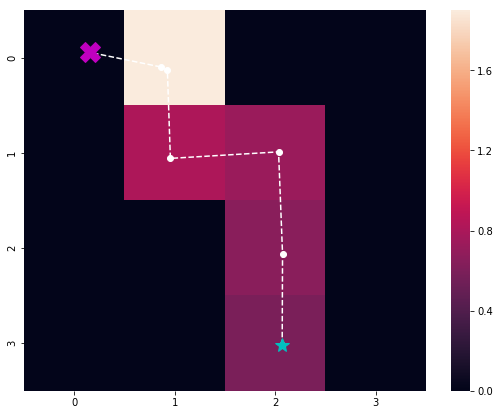

In [23]:
ET(GW4p1, 0.9)

## Exercise 4**: TD(lambda)

Implement TD(lambda) algorithm and use it for solving example 6.5. Create a table/plot on the effect of lambda in the performance of the algorithm.

*) - not mandatory

In [17]:
def SarsaLambda(
    gw: GridWorld,
    maxiters: 'number of iterations, no early stopping',
    policy: 'Callable(q, state_index, eps) -> action_index',
    eps_schedule: 'Callable(iteration, previous_eps?) -> eps',
    alpha_schedule: 'Callable(episode_num, previous_alpha?) -> alpha',
    gamma: 'constant discount factor',
    lambda_,
    max_episode_length = 200,
) -> 'action-value table - 2D array: state_indices×action_indices':
    
    sa_dims = (gw.get_number_of_states(), gw.get_number_of_actions())
    Q = np.zeros(sa_dims)
    eps = None
    alpha = None
    
    for i in range(1, maxiters+1):
        E = np.zeros(sa_dims)
        
        eps = eps_schedule(i, eps)
        alpha = alpha_schedule(i, alpha)

        state = gw.get_init_state()
        state_index = gw.get_state_index(state)
        action_index = policy(Q, state_index, eps)
        j = 0
        while not gw.is_terminal(state)  and j < max_episode_length:
            j += 1
            
            next_state, reward = gw.take_action(state, gw.which_action(action_index))
            next_state_index = gw.get_state_index(next_state)
            
            next_action_index = policy(Q, next_state_index, eps)
            
            delta = reward + gamma*Q[next_state_index, next_action_index] - Q[state_index, action_index]
            
            E[state_index, action_index] += 1
            
            Q += alpha*delta*E
            E *= gamma*lambda_
            
            state = next_state
            state_index = next_state_index
            action_index = next_action_index
        
    return Q


In [18]:
q = SarsaLambda(
    gw=GW6p5,
    maxiters=20000,
    policy=eps_greedy_policy,
    eps_schedule=lambda a,b: 0.1,
    alpha_schedule=constant_alpha_schedule_factory(0.5),
    gamma=1,
    lambda_=0.1
)
print_action_value(q, GW6p5)
print_resulting_greedy_policy(q, GW6p5)

Action-value table:
State      ↑       ↓       ←       →  
(0, 0)  -19.97  -19.98  -19.88  -18.65
(0, 1)  -18.32  -18.33  -19.20  -17.38
(0, 2)  -17.37  -16.45  -18.33  -15.94
(0, 3)  -16.25  -15.74  -17.47  -14.53
(0, 4)  -14.82  -16.49  -16.08  -13.43
(0, 5)  -15.42  -14.41  -15.26  -12.77
(0, 6)  -12.60  -13.08  -13.88  -10.48
(0, 7)  -11.00  -11.46  -12.69  -10.05
(0, 8)   -9.96  -11.71  -11.64   -9.71
(0, 9)   -9.04   -7.10  -12.05   -9.24
(1, 0)  -19.53  -20.52  -19.76  -17.82
(1, 1)  -18.82  -18.73  -19.41  -17.34
(1, 2)  -17.18  -16.52  -18.80  -17.22
(1, 3)  -16.55  -15.77  -17.30  -13.73
(1, 4)  -15.14  -15.82  -15.96  -12.92
(1, 5)  -13.02  -13.92  -15.68  -13.62
(1, 6)  -12.30  -12.00  -13.20  -10.58
(1, 7)  -13.79  -12.18  -12.30   -9.30
(1, 8)  -11.28  -11.99  -10.74  -11.41
(1, 9)   -9.74   -5.29  -11.53   -8.87
(2, 0)  -19.51  -20.59  -19.83  -18.56
(2, 1)  -19.37  -19.62  -20.32  -16.22
(2, 2)  -18.03  -17.72  -17.64  -15.11
(2, 3)  -15.94  -15.86  -17.71  -15.28
(2, 4